# Fitting a GLM using glm_utils

This example loosely follows the approach taken in Coen et al. (2014), where individual GLMs are fitted to different covariates which are then ranked by their performance. An alternative approach - in which a single model that contains all features is fitted - is illustrated in [multiple_inputs.ipynb](link).

In [1]:
import glm_utils
import matplotlib.pyplot as plt
import numpy as np
import sklearn.linear_model
import sklearn.model_selection

from demo_utils import get_data
plt.style.use('ncb.mplstyle')

# Generate toy data 
The stimulus `x` (`[time, stimuli]`) corresponds to four stimuli - for instance the distance, angle, velocity, and acceleration of flies.

The response `y` (`[time,]`) is produced by filtering each of the four stimuli in `x` with a filter (given by `filters`) and summing.

The filters are defined with the righmost value (delay 0) being closest to the response and the leftmost being furthest into the past (delay -50)

x: (100000, 4), y: (100000,), filters (50, 4)


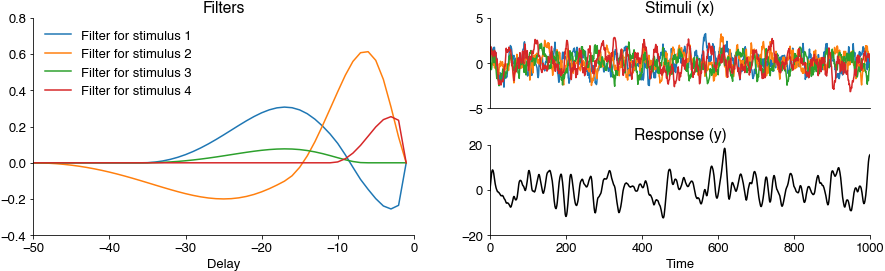

In [2]:
x, y, filters = get_data(npoints = 100_000)

nb_points, nb_stim = x.shape
filter_duration = filters.shape[0]
T = np.arange(-filter_duration, 0)

print(f"x: {x.shape}, y: {y.shape}, filters {filters.shape}")
plt.figure(figsize=[15,4])
plt.subplot(121)
plt.plot(T, filters)
plt.title('Filters')
plt.xlabel('Delay')
plt.legend([f'Filter for stimulus {f}' for f in range(1,5)])

plt.subplot(222)
plt.plot(x[:1000])
plt.title('Stimuli (x)')
plt.xticks(())

plt.subplot(224)
plt.plot(y[:1000], c='k')
plt.title('Response (y)')
plt.xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


## Time-delay-embedding
Since we are interested in what temporal patterns in the stimulus drive our response, we make time explicit using time delay embedding (aka delay-coordinate embedding). Thereby, the stimulus history 

For a given feature `x`, we build a matrix `X`, the rows of which contain all time points in `x` preceding `t` up to a maximum delay `nb_delays` such that `X[t, :] = x[t-nb_delays:t]`. Each row in `X` contains the stimulus history preceding each time point. 

Note: The first `nb_delays` samples are discarded, because the stimulus history for them is not defined. Accordingly, the resulting matrix `X` has `nb_delays` fewer samples than the input `x`. `time_delay_embedding` ensures that response `y` is still aligned with `X` after the embedding, by also discarding the first `nb_delays` samples from `y`.

Before embedding: x (100000,), y (100000,).
After embedding: X (99950, 50), y (99950,).


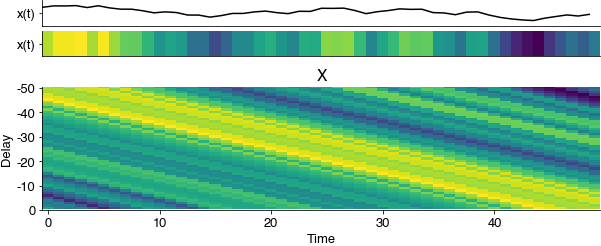

In [3]:
stimulus = 1
nb_delays = 50
print(f"Before embedding: x {x[:, stimulus].shape}, y {y.shape}.")
X, y_m = glm_utils.preprocessing.time_delay_embedding(x[:, stimulus], y, window_size=nb_delays)
print(f"After embedding: X {X.shape}, y {y_m.shape}.")

plt.figure(figsize=(10, 5))
plt.subplot(9, 1, 3)
plt.plot(x[100+nb_delays:150+nb_delays, stimulus], c='k')  # shift by `window_size` to account for cut-off intialy stimulus values
plt.yticks((0,), labels=['x(t)'])
plt.xticks(())

plt.subplot(9, 1, 4)
plt.imshow(x[100+nb_delays:150+nb_delays, stimulus:stimulus+1].T)  # shift by `window_size` to account for cut-off intialy stimulus values
plt.yticks((0,), labels=['x(t)'])
plt.xticks(())

plt.subplot(2, 1, 2)
plt.imshow(X[100:150, ::-1].T)
plt.yticks(np.arange(0, nb_delays+1, 10), np.arange(-nb_delays, 1, 10))
plt.title('X')
plt.xlabel('Time')
plt.ylabel('Delay')
plt.show()

## Define a basis
To reduce the number of covariates and enforce smooth filters, we use basis functions. The chosen basis function uses a series of raised cosine bumps that broaden with the delay. This broadening captures the fact that filters often are sharpest close to the response (small delays).

The basis is applied to the delay-embedded data `X` using `BasisProjection`, which has two functions: 
- `transform` - project your data from a time domain representation the to basis `[T, delays]` -> `[T, basis coefs]`.
- `inverse_transform` - invert the basis projection to recover the time domain presentation from basis coefficients `[T, basis coefs]` -> `[T, delays]`.

See [basis_functions](basis_functions.ipynb) for a list of all available bases.

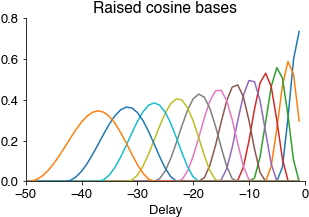

Before basis projection: X (99950, 50),  y (99950,).
After basis projection: X (99950, 12),  y (99950,).


In [4]:
# construct the basis functions
B = glm_utils.bases.raised_cosine(0, 12, [0, 36], 16, nb_delays)

# intialize basis_projection object
basis_projection = glm_utils.preprocessing.BasisProjection(B)
_, nbases = B.shape
T = np.arange(-nb_delays, 0)

plt.figure(figsize=(5,3))
plt.plot(T, B)
plt.title('Raised cosine bases')
plt.xlabel('Delay')
plt.show()

print(f"Before basis projection: X {X.shape},  y {y_m.shape}.")
X_b = basis_projection.transform(X)
print(f"After basis projection: X {X_b.shape},  y {y_m.shape}.")

## Split data into train and test set
The data is split into two parts: a "training set" for fitting the model and a "test set" for evaluating the model. Evaluating on data not used for fitting prevents [overfitting](https://en.wikipedia.org/wiki/Overfitting).

In [5]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_b, y_m, test_size=0.2)
print(f"Shape of training set: {X_train.shape}, test set: {X_test.shape}")

Shape of training set: (79960, 12), test set: (19990, 12)


## Fit the model
Since `y` is a continuous variable, we use `LassoCV` - linear regression with L1 regularization. For binary `y` (e.g. the presence or absence of a spike or behavioral event), use `LogisticRegressionCV`.

The test score, [r2](https://en.wikipedia.org/wiki/Coefficient_of_determination) for `LassoCV`, is 0.64 - the stimulus explains 64% of the variance in the response.

In [6]:
lr = sklearn.linear_model.LassoCV(max_iter=10_000)
lr.fit(X_train, y_train)
print(f"Test score (r2): {lr.score(X_test, y_test):1.2f}.")

Test score (r2): 0.64.


## Reconstruct the filter from the model coefficients
The model coefficients do not directly correspond to the time-domain filter - rather, they constitute a set weights for each basis function in the bases. We can recover the time-domain filter using `inverse_transform`.

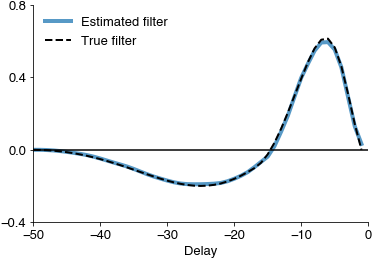

In [7]:
filter_shape = basis_projection.inverse_transform(lr.coef_)

plt.plot(T, filter_shape.T, linewidth=4, alpha=0.75, label='Estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters[:, stimulus], '--k', linewidth=2, label='True filter')
plt.axhline(c='k')
plt.xlabel('Delay')
plt.yticks(np.arange(-0.4, 1.0, 0.4))
plt.legend()
plt.show()

## Run the pipeline for independent train-test splits to obtain error bars on the filters and scores
To compare the test scores and filters for different stimuli, we need an estimate of the uncertainty in these quantities. 
Error bars on the filters and the test scores can be obtained by fitting the model fit independent train-test splits.

To speed things up, we do this 50 times - if you want to reliably estimate a 95% confidence interval you probably need at least 1000 splits. 

In [8]:
nb_splits = 50  # number of train-test splits to use for fitting

filter_shapes = np.zeros((nb_stim, nb_splits, nb_delays))
filter_norms = np.zeros((nb_stim, nb_splits))
test_scores = np.zeros((nb_stim, nb_splits))

# initialize the lasso regression object
lr = sklearn.linear_model.LassoCV(max_iter=10_000)  # increase max_iter to ensure convergence

# loop through all features
for stim in range(nb_stim):
    Xs, ys = glm_utils.preprocessing.time_delay_embedding(x[:, stim], y, window_size=nb_delays)
    Xs_b = basis_projection.transform(Xs)
    
    for split in range(nb_splits):
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Xs_b, ys, test_size=0.5)
        lr.fit(X_train, y_train)

        # eval model and reconstruct filters
        basis_weights = lr.coef_
        filter_shape = basis_projection.inverse_transform(basis_weights)
        filter_shapes[stim, split, :] = filter_shape
        filter_norms[stim, split] = np.linalg.norm(filter_shape)
        test_scores[stim, split] = lr.score(X_test, y_test)

The stimuli can be ranked by their test scores. The test score is proportional to the norm of the filters if all stimuli have the same scale.

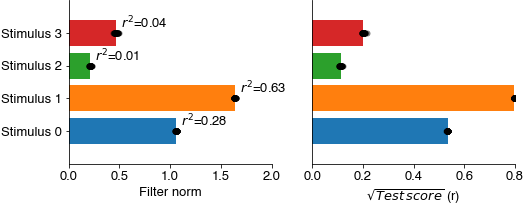

In [9]:
stim_names = [f'Stimulus {ii}' for ii in range(nb_stim)]
stim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8, 3))
plt.subplot(121)
for stim in range(nb_stim):
    plt.plot(filter_norms[stim], [stim]*nb_splits, 'ok', alpha=0.5)
    plt.barh(stim, np.mean(filter_norms[stim]))
    plt.text(np.mean(filter_norms[stim]) + 0.05, stim + 0.15, s=f"$r^2$={np.mean(test_scores[stim]):0.2f}")
plt.yticks(np.arange(nb_stim), stim_names)
plt.xlabel('Filter norm')
plt.xlim(0)

plt.subplot(122)
for stim in range(nb_stim):
    plt.plot(np.sqrt(test_scores[stim]), [stim]*nb_splits, 'ok', alpha=0.5)
    plt.barh(stim, np.mean(np.sqrt(test_scores[stim])))
plt.yticks(())
plt.xlabel('$\sqrt{Test\,score}$ (r)')
plt.xlim(0)
plt.show()

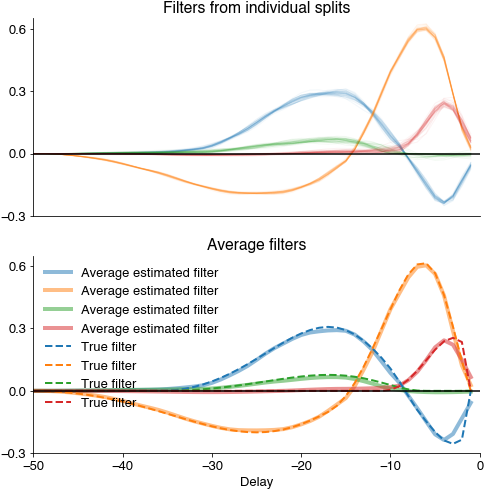

In [10]:
plt.figure(figsize=(8, 8))
plt.subplot(211)
for stim in range(nb_stim):
    plt.plot(T, filter_shapes[stim,...].T, linewidth=1, alpha=0.05, color=stim_colors[stim])
plt.title('Filters from individual splits')
plt.axhline(0, color='k')
plt.yticks(np.arange(-0.3, 0.61, 0.3))
plt.ylim(-0.3, 0.65)
plt.xticks(())

plt.subplot(212)
plt.plot(T, np.mean(filter_shapes, axis=1).T, linewidth=4, alpha=0.5, label='Average estimated filter')
plt.gca().set_prop_cycle(None)
plt.plot(T, filters, '--', linewidth=2, label='True filter')
plt.axhline(0, color='k')
plt.xlabel('Delay')
plt.yticks(np.arange(-0.3, 0.61, 0.3))
plt.ylim(-0.3, 0.65)
plt.legend(loc='upper left')
plt.title('Average filters')
plt.show()